# Проект введение в машинное обучение

##  Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов оператора мобильной связи. Необходимо построить модель для задачи классификации, которая выберет подходящий тариф. Параметр качества модели accuracy (долю правильных ответов) необходимо довести до 0.75.

### План проекта

1. [Изучение общей информации](#introduction) <br>
2. [Разбиение данных на выборки](#paragraph2) <br>
3. [Исследование моделей](#paragraph3) <br>
   3.1 [Исследование модели решающего дерева](#subparagraph1) <br>
   3.2 [Исследование модели случайного леса](#subparagraph2) <br>
   3.3 [Исследование модели логистической регрессии](#subparagraph3) <br>
4. [Проверка модели на тестовой выборке](#paragraph4) <br>

### 1. Изучение общей информации о данных
<a name="introduction"></a>

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('/datasets/users_behavior.csv')
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Данные включают в себя 5 колонок. <br>
Одну колонку с целевым признаком - принадлежность к тарифу "Ультра" (признак "is_ultra"), и четыре столбца с признаками-характеристиками: <br>
"calls" - количество звонков; <br>
"minutes" - суммарная длительность звонков; <br>
"messages" - количество sms-сообщений; <br>
"mb_used" - израсходованный интернет-трафик, Мб. <br>

In [2]:
#посмотрим на количество пользователей тарифа "ультра"
data['is_ultra'].value_counts()
is_ultra_percentage = (data[data['is_ultra'] == 1]['is_ultra'].count())/data['is_ultra'].count()
print('Процент пользователей тарифа "Ультра": {:.1%}'.format(is_ultra_percentage))

Процент пользователей тарифа "Ультра": 30.6%


In [3]:
#изменим формат столбца 'is_ultra' на булевый тип
data['is_ultra'] = data['is_ultra'].astype('bool')

### 2. Разбиение данных на выборки
<a name="paragraph2"></a>

Поскольку в данных отсутствует спрятанная тестовая выборка, разобьем их на три части: обучающую, валидационную и тестовую - в соотношении 3:1:1. <br>
На первом шаге отведем 60% данных - на обучающую выборку, 40% - на валидационную выборку. <br>
На втором шаге разобьем валидационную выборку на две подвыборки - на валидационную и тестовую в соотношении 1:1. <br>

In [4]:
#Шаг 1. Разделим исходный датасет на обучающую и валидационную выборки
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(data, test_size = 0.4, random_state = 1234)

In [5]:
#Шаг 2. Разделим валидационную выборку пополам - на валидационную и на тестовую
df_valid, df_test = train_test_split(df_valid, test_size = 0.5, random_state = 1234)

In [6]:
#Проверим распределение данных на выборке
print('Объем обучающей выборки: {:.1%} данных'.format(len(df_train)/len(data)))
print('Объем валидационной выборки: {:.1%} данных'.format(len(df_valid)/len(data)))
print('Объем тестовой выборки: {:.1%} данных'.format(len(df_test)/len(data)))

Объем обучающей выборки: 60.0% данных
Объем валидационной выборки: 20.0% данных
Объем тестовой выборки: 20.0% данных


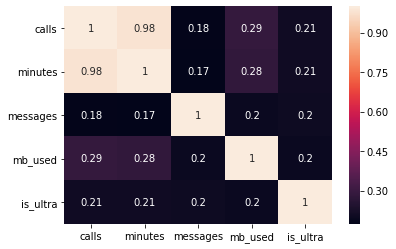

In [7]:
#посмотрим на матрицу корреляций признаков, для выявления потенциальной проблемы мультиколлинеарности
import seaborn as sns 
sns.heatmap(data.corr(), annot=True)

Наблюдается высокая положительная корреляция между минутами  разговора ('minutes') и звонками ('calls'), равная 0.98. Исключим из датасета признак 'minutes' для избежания проблемы мультиколлинеарности при построении логистической регрессии.

In [8]:
data = data.drop('minutes', axis=1)

Выделим целевой признак и описательные признаки в каждом датасете.

In [9]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra'] 
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

### 3. Исследование моделей
<a name="paragraph3"></a>

Поскольку перед нами стоит задача классификации - задача выбора подходящего тарифа, будем строить следующие модели:<br>
1. Решающее дерево <br>
2. Случайный лес <br>
3. Логистическая регрессия <br>

### 3.1 Исследование модели решающего дерева
<a name="subparagraph1"></a>

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [11]:
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1234, max_depth=depth)
    #обучение модели на обучающей выборке
    model.fit(features_train, target_train)
    #посчитаем качество модели на валидационной выборке 
    result = model.score(features_valid, target_valid)
    if result > best_result_dt:
        #сохраним наилучшую модель
        best_model_dt = model
        #сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result_dt = result 
        best_depth_dt = depth
        

print("Accuracy наилучшей модели на валидационной выборке:", best_result_dt, "Глубина дерева:", best_depth_dt)

Accuracy наилучшей модели на валидационной выборке: 0.8320373250388803 Глубина дерева: 7


### 3.2 Исследование модели случайного леса
<a name="subparagraph2"></a>

In [12]:
#переберем в цикле модели случайного леса с числом деревьем от 1 до 100 и глубиной от 1 до 10
from sklearn.ensemble import RandomForestClassifier
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 10):
    for est in range(1, 100):
        model = RandomForestClassifier(random_state=1234, n_estimators = est, max_depth=depth)
        #обучение модели на обучающей выборке
        model.fit(features_train, target_train)
        #посчитаем качество модели на валидационной выборке 
        result = model.score(features_valid, target_valid)
        if result > best_result:
            #сохраним наилучшую модель
            best_model = model
            #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_result_rf = result 
            best_depth_rf = depth
            best_est_rf = est
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result_rf, "Глубина дерева:", best_depth_rf, "Количество деревьев:", est)

Accuracy наилучшей модели на валидационной выборке: 0.8351477449455676 Глубина дерева: 9 Количество деревьев: 99


### 3.3 Исследование модели логистической регрессии
<a name="subparagraph3"></a>

In [15]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=123)
#обучение модели на обучающей выборке
log_reg.fit(features_train, target_train)
#расчет качества модели на валидационной выборке
lr_result = log_reg.score(features_valid, target_valid)
print(lr_result)

0.7216174183514774


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
#выведем сводную информацию о моделях
all_models = pd.DataFrame({'Название модели' : ['DecisionTree', 'RandomForest', 'LogisticRegression'], 'Гиперпараметры модели' : [{'max_depth':best_depth_dt}, {'max_depth':best_depth_rf, 'n_estimators':est}, {}], 'Доля правильных ответов' : [best_result_dt, best_result_rf, lr_result]})
display(all_models)

,Название модели,Гиперпараметры модели,Доля правильных ответов
0,DecisionTree,{'max_depth': 7},0.832037
1,RandomForest,"{'max_depth': 9, 'n_estimators': 99}",0.835148
2,LogisticRegression,{},0.721617


В результате проведенных экспериментов на валидационной выборке можно заключить, что самую высокую долю правильных ответов демонстрирует случайный лес с количеством деревьев, равным 99, и глубиной дерева, соответствующей 9. 

## 4. Проверка модели на тестовой выборке
<a name="paragraph4"></a>

In [18]:
#проверим, как ведет себя модель с наилучшей долей правильных ответов на тестовой выборке
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=99, max_depth = 9, random_state=123)
model.fit(features_test, target_test)
predictions_test = model.predict(features_test)
accuracy_score(target_test, predictions_test)

0.9206842923794712

На тестовой выборке модель случайного леса продемонстрировала значение accuracy выше, чем на валидационной выборке: 0,921 против 0,835. Следовательно, на тестовой выборке модель случайного леса также демонстрирует высокую долю правильных ответов.

**Вывод**<br>
Можно заключить, что наилуший результат для решения представленной задачи бинарной классификации демонстрирует модель случайного леса.